In this lab we will learn, how vector representations of different objects can be obtained, and how they can be utilized for recommendations and search.

# 1. If there's no ocean perch in Innopolis...

When you find something that you like - whether it is a poem, song, or image, it's often useful to have an option to find similar items, such that you can enjoy songs of the same kind, for example. For this there exist **recommender systems**, and we will build one today. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have ocean perch in Innopolis?

The recommender system will be based on the vector-space model + dimensionality reduction + cosine similarity measure.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1.1. Reading the dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/IUCVLab/information-retrieval/blob/main/datasets/nutrition.csv

In [2]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
names = [name.split(',')[0] for name in names]

dimensions = dataset.columns[1:]

print("Names:", ", ".join(names[:5]), ", ...")
print("Classes:", ", ".join(list(set(classes_list))[:2]), ", ...")
print("Dimensions:", ", ".join(dimensions[:5]), ", ...")

dataset.head()

Names: Asparagus, Bell Pepper, Broccoli, Carrot, Cauliflower , ...
Classes: Fruits Serving Size (gram weight/ounce weight), Vegetables, Serving Size (gram weight/ ounce weight) , ...
Dimensions: Calories, Calories from Fat, Total Fat 1, Total Fat 2, Sodium 1 , ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## 1.2. Assigning colors each food item
Building a `color_list` which attributes a color to each item.

In [3]:
classes = list(set(classes_list))
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
print(class_colors)
color_list = [class_colors[a] for a in classes_list]

{'Fruits Serving Size (gram weight/ounce weight)': 'red', 'Vegetables, Serving Size (gram weight/ ounce weight)': 'green', 'Seafood, Serving Size (84 g/3 oz)': 'blue'}


## 1.3. Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [4]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(12,8))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X, Y, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
    
def show_points_3d(X, Y, Z):
    global color_list
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## 1.4. Data Visualization
Matrix `A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 features). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw values, columns are objects (61, 22)


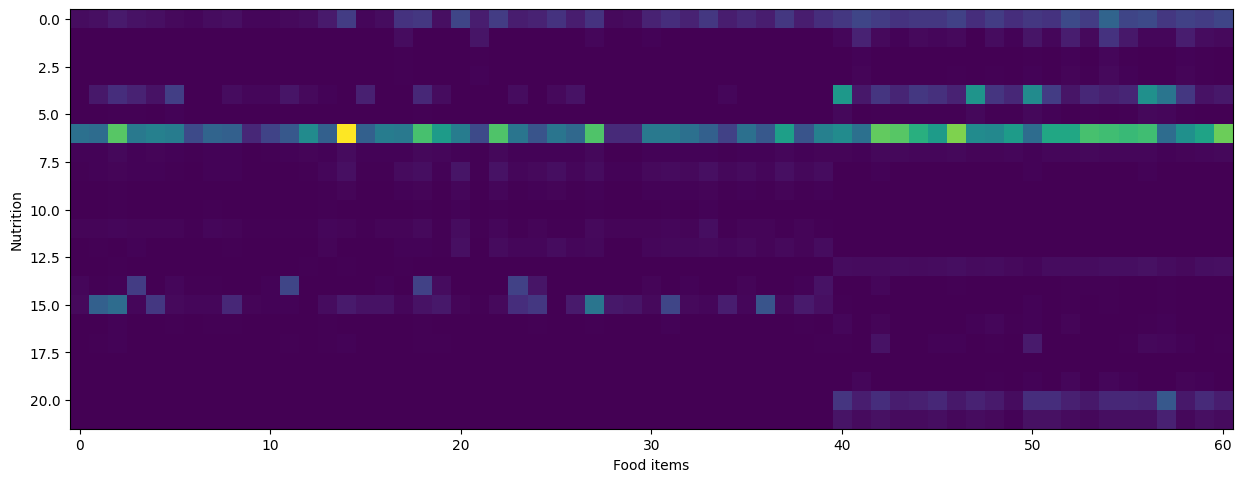

2 random dimensions distribution


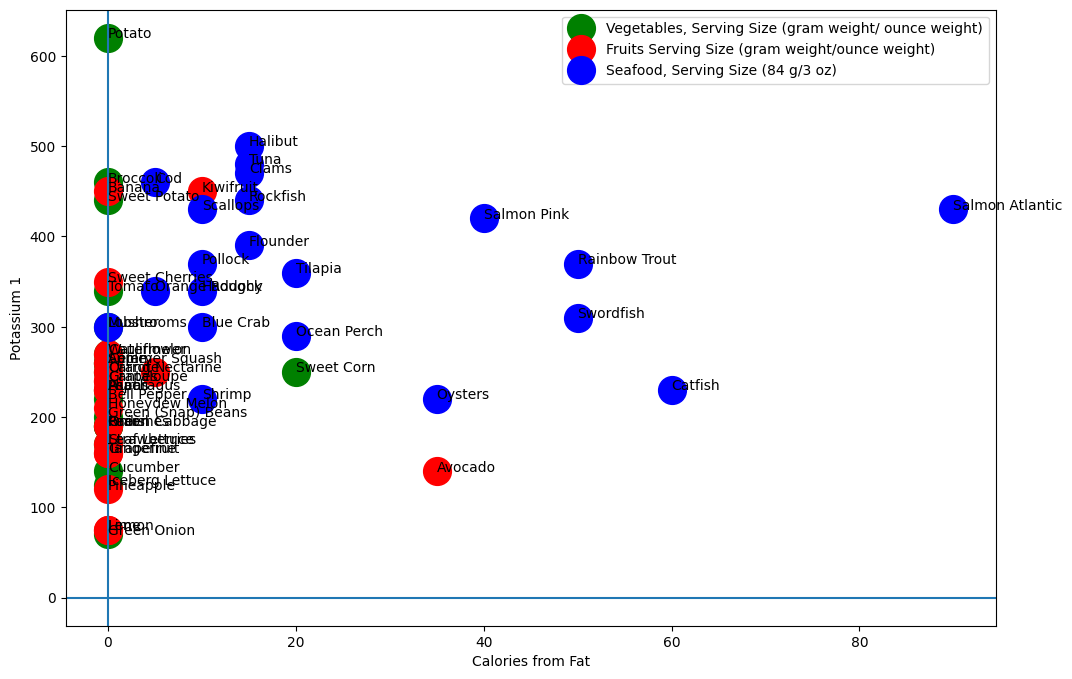

In [5]:
A = np.array(dataset.values[1:,1:-1].astype(float))
print("Raw values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutrition")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## 1.5. [TASK] Dimensionality reduction with Principal Components Analysis
Principal components are the dimensions, which express **dataset diversity** in the best way: the **variance** is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's keep 3 principal components. **Fill in the code to apply PCA to our data**.

In [6]:
from sklearn.decomposition import PCA
k = 3
pca = PCA(n_components=k)
#TODO apply PCA to matrix A, and save the results to A_pca
A_pca = pca.fit_transform(A)

In [7]:
assert A_pca.shape == (61, 3)

Check how much variance is explained by the first `k` components. Refer to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [11]:
# TODO compute the value
explainted_variance_ratio =  sum(pca.explained_variance_ratio_[:k])

In [13]:
assert explainted_variance_ratio > 0.9, "Something went wrong with PCA"

Now, let's **visualize** the data after transformation applied.

2 first dimensions


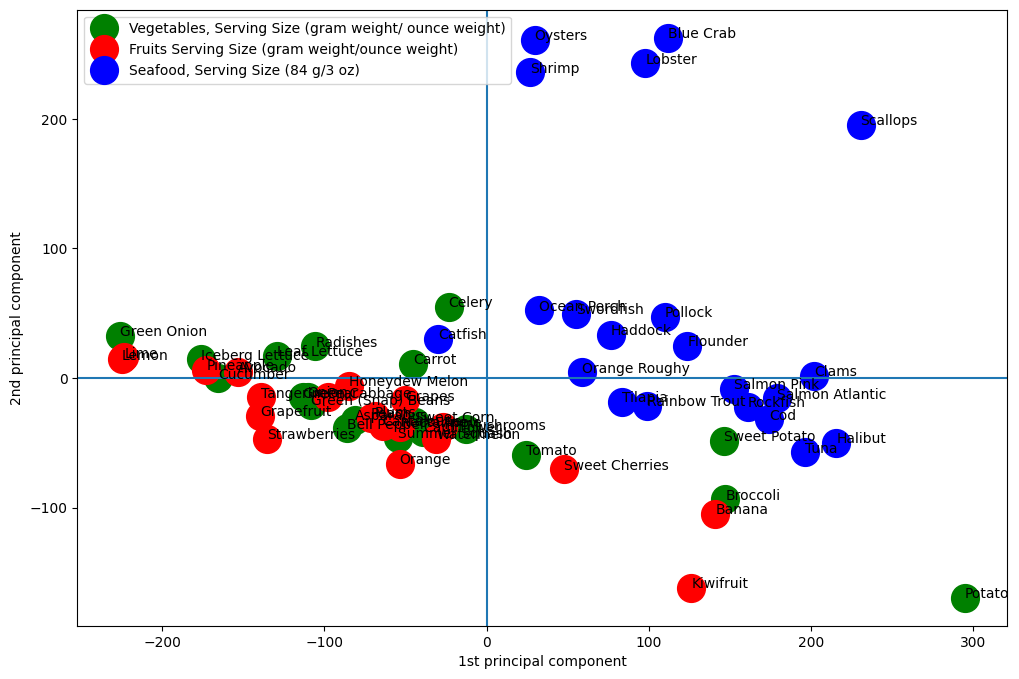

3 first dimensions


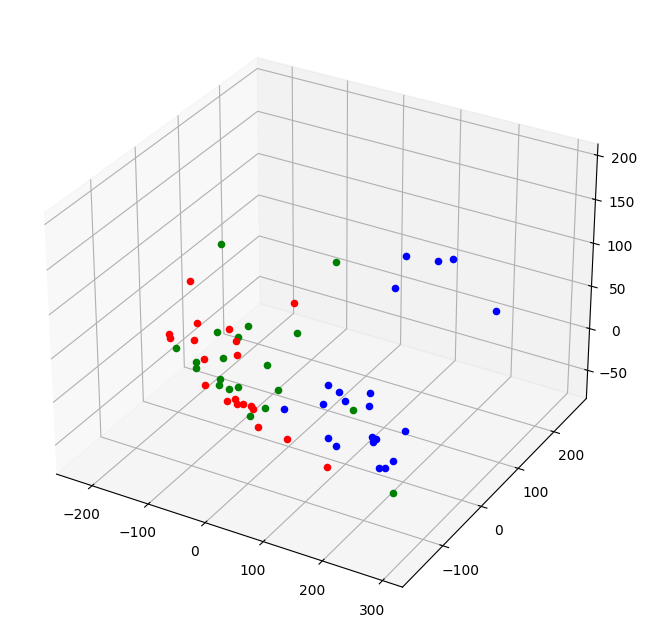

In [14]:
print("2 first dimensions")
show_points_2d(A_pca.T[0], A_pca.T[1], "1st principal component", "2nd principal component")
print("3 first dimensions")
show_points_3d(A_pca.T[0], A_pca.T[1], A_pca.T[2])

## 1.6. [TASK] Dimensionality reduction with SVD

SVD is not appying centering at the first stage. Instead of variance, it preserves cosine similaity measure, which is more interesting in our case.

In [15]:
from numpy.linalg import svd
k = 3

#TODO apply SVD to matrix A, and save the results to A_svd
U, sigma, V = svd(A, full_matrices=True)

A_svd = U[:, :k] @ np.diag(sigma)[:k, :k]
print(A_svd.shape)

(61, 3)


In [16]:
assert A_svd.shape == (61, 3)

How it looks like?

2 first dimensions


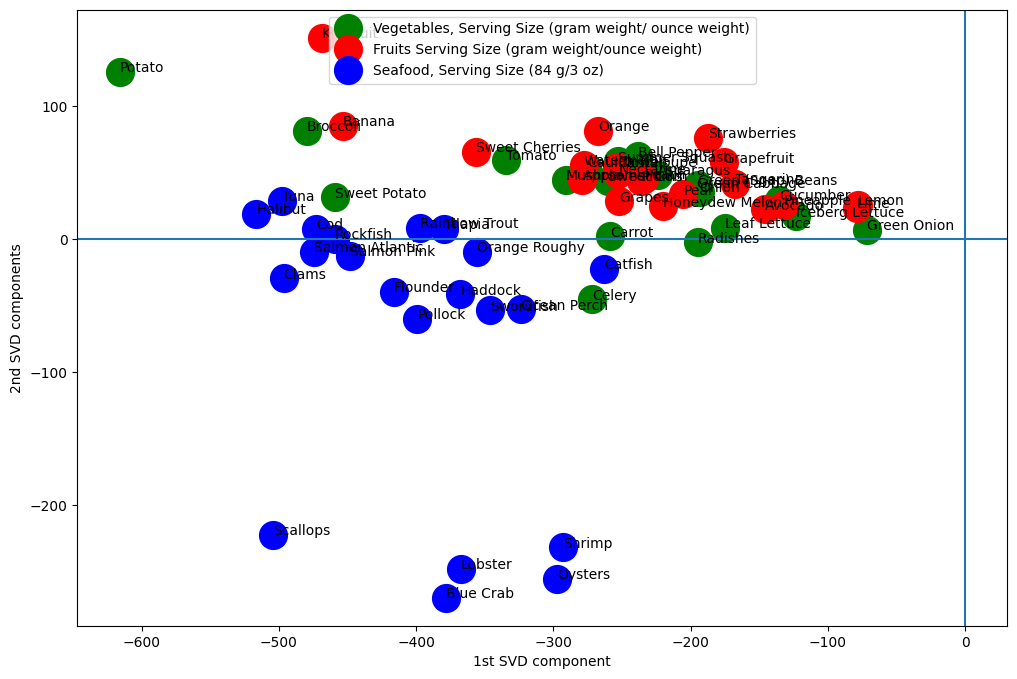

3 first dimensions


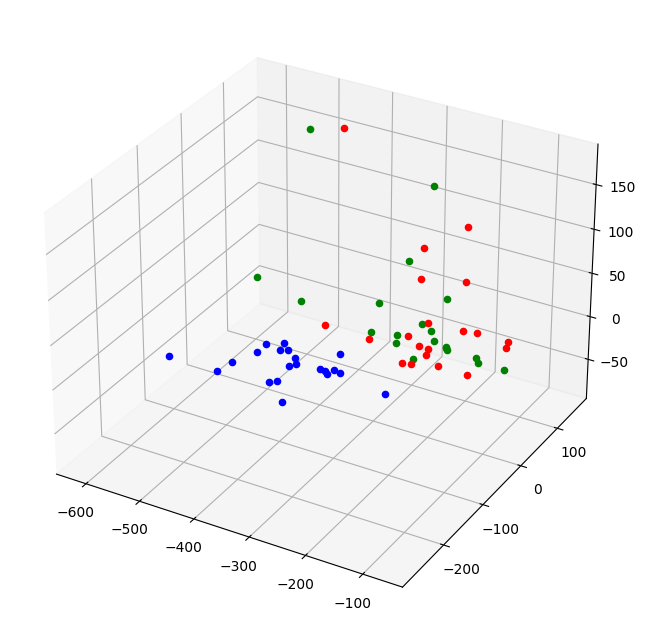

In [18]:
print("2 first dimensions")
show_points_2d(A_svd.T[0], A_svd.T[1], "1st SVD component", "2nd SVD components")
print("3 first dimensions")
show_points_3d(A_svd.T[0], A_svd.T[1], A_svd.T[2])

## 1.7. [TASK] Norming
It can happen, that some food is more "watered" than the other. See, how different are celery and potato in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ distance to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same" even if nutrition is of different scale. Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

In [ ]:
def norm_vectors(A):
    An = A.copy()
    #TODO write here a code that will norm each vector (we consider L2 norm here)
    
    return An

How it looks now?

2 first dimensions of PCA


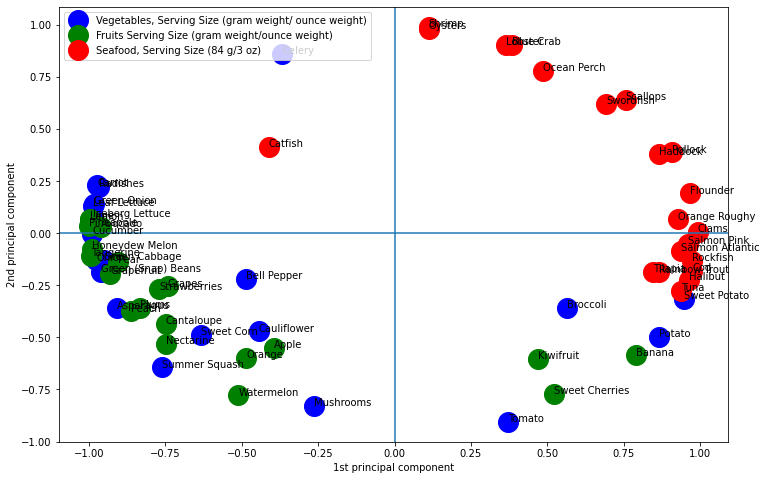

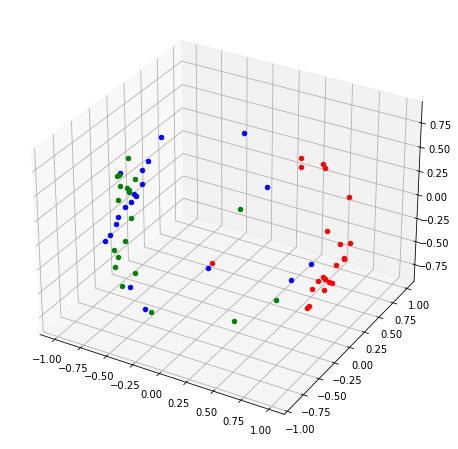

In [ ]:
A_pca_norm = norm_vectors(A_pca)

print("2 first dimensions of PCA")
show_points_2d(A_pca_norm.T[0], A_pca_norm.T[1], "1st principal component", "2nd principal component")
show_points_3d(A_pca_norm.T[0], A_pca_norm.T[1], A_pca_norm.T[2])

2 first dimensions of SVD


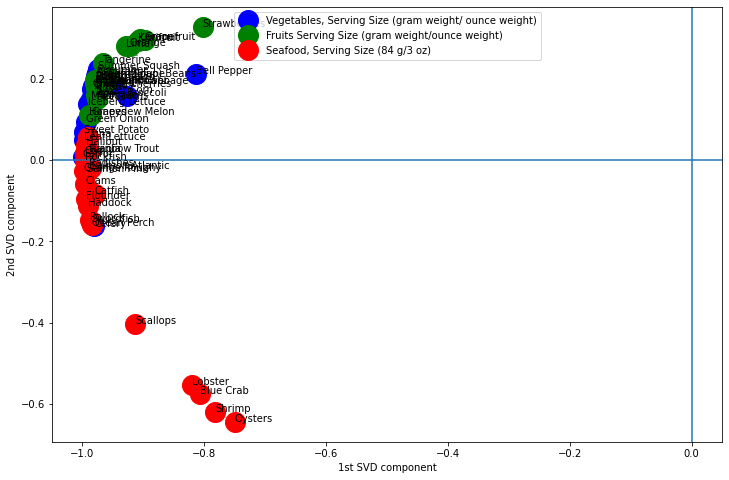

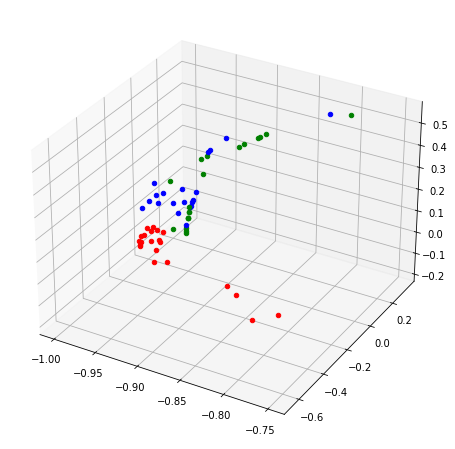

In [ ]:
A_svd_norm = norm_vectors(A_svd)

print("2 first dimensions of SVD")
show_points_2d(A_svd_norm.T[0], A_svd_norm.T[1], "1st SVD component", "2nd SVD component")
show_points_3d(A_svd_norm.T[0], A_svd_norm.T[1], A_svd_norm.T[2])

## 1.8. [TASK] Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend the closest food items in terms of nutrition. 

**Please, write the code that will return $k$ closest food items to the provided query vector.**

In [ ]:
def find_k_closest(query, dataset, k=6):
    #TODO write here the code that will find k closest rows in dataset in terms of cosine similarity
    return []

Ok, let's see how your recommendations work :)

For:		 Ocean Perch


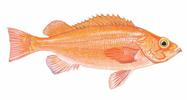




========== Recommending with PCA ==============




	Shrimp | similarity = 0.808


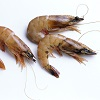


	Scallops | similarity = 0.815


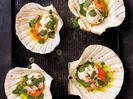


	Blue Crab | similarity = 0.821


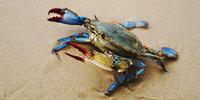


	Haddock | similarity = 0.845


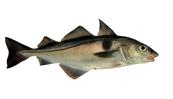


	Swordfish | similarity = 0.966


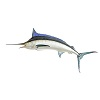

In [ ]:
import os
from IPython.display import Image

recommend_to = 48
print("For:\t\t", names[recommend_to])
fn = f'../../datasets/nutr_img/{names[recommend_to].lower()}.jpg'
if os.path.exists(fn):
    display(Image(filename=fn))

print("\n\n\n========== Recommending with PCA ==============\n\n\n")

r = find_k_closest(A_pca_norm[recommend_to,:], A_pca_norm)

for k in r:
    if recommend_to != k: # exclude itself 
        print(f"\n\t{names[k]} | similarity = { np.dot(A_pca_norm[k],  A_pca_norm[recommend_to]) :.3}")
        fn = f'../../datasets/nutr_img/{names[k].lower()}.jpg'
        if os.path.exists(fn):
            display(Image(filename=fn))




========== Recommending with SVD ==============




	Clams | similarity = 0.995


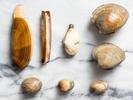


	Flounder | similarity = 0.998


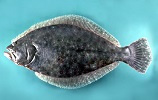


	Haddock | similarity = 0.999


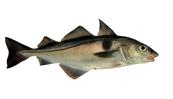


	Pollock | similarity = 1.0


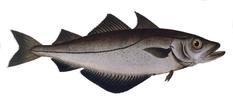


	Swordfish | similarity = 1.0


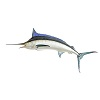

In [ ]:
print("\n\n\n========== Recommending with SVD ==============\n\n\n")
r = find_k_closest(A_svd_norm[recommend_to,:], A_svd_norm)
for k in r:
    fn = f'../../datasets/nutr_img/{names[k].lower()}.jpg'
    if recommend_to != k: # exclude itself 
        print(f"\n\t{names[k]} | similarity = { np.dot(A_svd_norm[k],  A_svd_norm[recommend_to]) :.3}")
        if os.path.exists(fn):
            display(Image(filename=fn))